In [1]:
import jax.numpy as jnp
import numpy as np
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_default_device", jax.devices()[1])

import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *
from EquationModel import OperatorModel,OperatorPDEModel
from evaluation_metrics import compute_results    
from data_utils import MinMaxScaler
from evaluation_metrics import get_nrmse

from Kernels import log1pexp,inv_log1pexp, get_gaussianRBF
from Kernels import (
    get_centered_scaled_poly_kernel,
    get_anisotropic_gaussianRBF,
    fit_kernel_params
)
from EquationModel import CholInducedRKHS, OperatorPDEModel
from functools import partial

from Optimizers.full_jacobian import CholeskyLM, SVD_LM
from Optimizers.solvers_base import *

# import Optimizers
# import importlib
# importlib.reload(Optimizers)
# from Optimizers import CholeskyLM,SVD_LM,SketchedLM

import time
from jax.scipy.sparse.linalg import cg
from jax.scipy.linalg import solve,cho_factor,cho_solve

# import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from scipy.spatial import distance
from matplotlib import cm
import time
from mpl_toolkits.mplot3d import Axes3D
# from pyDOE import lhs
# #    import sobol_seq
import os
from parabolic_data_utils import (
    build_burgers_data,build_tx_grid,
    build_tx_grid_chebyshev,setup_problem_data,
    GP_Sampler_1D_Pinned
)
from plotting import plot_input_data,plot_compare_error
from evaluation_metrics import compute_results
from matplotlib import ticker

plt.style.use("default")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    'font.size': 20
})

/home/juanfelipe/anaconda3/envs/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


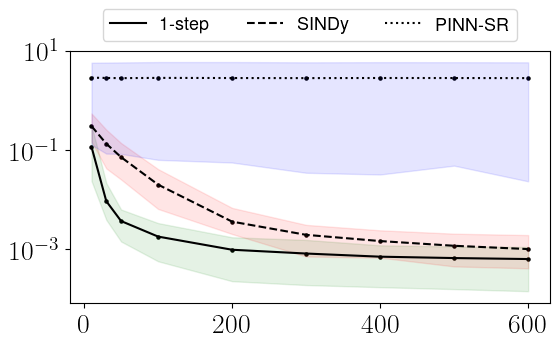

In [2]:
# u filtering error vs. N
plt.figure(figsize=(6,4))
N_OBS = [10,30,50,100,200,300,400,500,600]
##### 1 step
errors_1_5 = jnp.load('../i_smpl_errors/e_ismpl_1_5.npy', allow_pickle=True).item()
u_s = jnp.array([jnp.mean(jnp.array(el)) for el in errors_1_5['u']])
u_upper = jnp.array([jnp.nanmax(jnp.array(el)) for el in errors_1_5['u']])
u_lower = jnp.array([jnp.nanmin(jnp.array(el)) for el in errors_1_5['u']])
plt.plot(N_OBS,u_s, color = 'black', label = '1-step')
plt.scatter(N_OBS,u_s, s = 5, color = 'black')
plt.fill_between(N_OBS, u_lower, u_upper, alpha=.1, color = 'green')
##### SINDy
errors_SINDy = jnp.load('../i_smpl_errors/e_ismpl_SINDy.npy', allow_pickle=True).item()
u_s = jnp.array([jnp.mean(jnp.array(el)) for el in errors_SINDy['u']])
u_upper = jnp.array([jnp.nanmax(jnp.array(el)) for el in errors_SINDy['u']])
u_lower = jnp.array([jnp.nanmin(jnp.array(el)) for el in errors_SINDy['u']])
plt.plot(N_OBS,u_s,color = 'black', label = 'SINDy',linestyle='dashed')
plt.scatter(N_OBS,u_s,s = 5, color = 'black')
plt.fill_between(N_OBS, u_lower, u_upper, alpha=.1, color = 'red')
##### PINNSR
errors_PINNSR = jnp.load('../i_smpl_errors/e_ismpl_PINNSR.npy', allow_pickle=True).item()
u_s = jnp.array([jnp.mean(jnp.array(el)) for el in errors_PINNSR['u']])
u_upper = jnp.array([jnp.nanmax(jnp.array(el)) for el in errors_PINNSR['u']])
u_lower = jnp.array([jnp.nanmin(jnp.array(el)) for el in errors_PINNSR['u']])
plt.plot(N_OBS,u_s,color = 'black', label = 'PINN-SR',linestyle='dotted')
plt.scatter(N_OBS,u_s,s = 5, color = 'black')
plt.fill_between(N_OBS, u_lower, u_upper, alpha=.1, color = 'blue')

#### Settings of the plot
plt.yscale('log')
plt.minorticks_off()
plt.legend(fontsize=13,loc='upper center',bbox_to_anchor=(0.5, 1.2), ncol = 3)
plt.tight_layout()
plt.savefig('u_errors_varyIC.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            )

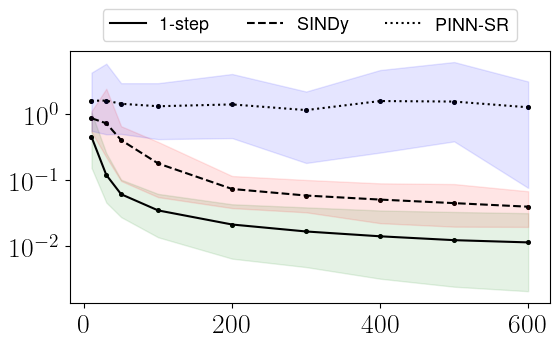

In [3]:
# P eql error vs. N
N_OBS = [10,30,50,100,200,300,400,500,600]
plt.figure(figsize=(6,4))
##### 1 step
errors_1_5 = jnp.load('../i_smpl_errors/e_ismpl_1_5.npy', allow_pickle=True).item()
P_s = jnp.array([jnp.mean(jnp.array(el)) for el in errors_1_5['Phat']])
P_lower = jnp.array([jnp.min(jnp.array(el)) for el in errors_1_5['Phat']])
P_upper = jnp.array([jnp.max(jnp.array(el)) for el in errors_1_5['Phat']])
plt.plot(N_OBS,P_s,color = 'black', label = '1-step')
plt.scatter(N_OBS,P_s,s = 7, color = 'black')
plt.fill_between(N_OBS, P_lower, P_upper, alpha=.1, color = 'green')
##### SINDy
errors_SINDy = jnp.load('../i_smpl_errors/e_ismpl_SINDy.npy', allow_pickle=True).item()
P_s = jnp.array([jnp.mean(jnp.array(el)) for el in errors_SINDy['Phat']])
P_lower = jnp.array([jnp.min(jnp.array(el)) for el in errors_SINDy['Phat']])
P_upper = jnp.array([jnp.max(jnp.array(el)) for el in errors_SINDy['Phat']])
plt.plot(N_OBS,P_s,color = 'black', label = 'SINDy',linestyle='dashed')
plt.scatter(N_OBS,P_s,s = 7, color = 'black')
plt.fill_between(N_OBS, P_lower, P_upper, alpha=.1, color = 'red')
##### PINNSR
errors_PINNSR = jnp.load('../i_smpl_errors/e_ismpl_PINNSR.npy', allow_pickle=True).item()
P_s = jnp.array([jnp.nanmean(jnp.array(el)) for el in errors_PINNSR['Phat']])
P_lower = jnp.array([jnp.min(jnp.array(el)) for el in errors_PINNSR['Phat']])
P_upper = jnp.array([jnp.max(jnp.array(el)) for el in errors_PINNSR['Phat']])
plt.plot(N_OBS,P_s,color = 'black', label = 'PINN-SR',linestyle='dotted')
plt.scatter(N_OBS,P_s,s = 7, color = 'black')
plt.fill_between(N_OBS, P_lower, P_upper, alpha=.1, color = 'blue')

#### Settings of the plot
plt.yscale('log')
plt.minorticks_off()
plt.legend(fontsize=13,loc='upper center',bbox_to_anchor=(0.5, 1.2), ncol = 3)
plt.tight_layout()
plt.savefig('P_errors_varyIC.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            )

## Sample IC with different points

In [4]:
def get_IC_obs(num_obs, run):
    # coeffs for burgers
    kappa = 0.01
    alpha = 1.

    # kernel in GP(0,K) to generate IC from GP
    kernel_GP = get_gaussianRBF(0.2)
    # grid to build IC
    x_pts = jnp.linspace(0,1,50)
    # IC
    u0_true_function = GP_Sampler_1D_Pinned(num_samples = 1,
                                            X = x_pts, 
                                            smooth = 2, # regularity
                                            kernel = kernel_GP,
                                            reg = 1e-8,
                                            seed = run
                                        )
    vec_u0_true_function = np.vectorize(u0_true_function[0])

    u_true_function,ut_true_function, interp,_,_ = (build_burgers_data(func_u0=vec_u0_true_function,
                                                                    kappa = kappa,
                                                                    alpha = alpha,
                                                                    k_timestep=0.0001,
                                                                    n_finite_diff=1999)
    )

    # size of coll grid
    num_grid_x, num_grid_t = 31, 26

    # get interior and bdry pts of coll grid
    tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],num_grid_t,num_grid_x,alpha = 0.5)

    # fine grid
    num_grid_points = 300
    t_fine,x_fine = jnp.meshgrid(jnp.linspace(0,1,num_grid_points),jnp.linspace(0,1,num_grid_points))
    tx_fine = jnp.vstack([t_fine.flatten(),x_fine.flatten()]).T

    # u vals at fine grid
    u_true = u_true_function(tx_fine)



    # coll and obs grid
    tx_all,tx_obs = setup_problem_data(tx_int,
                                    tx_bdy,
                                    num_obs,
                                    jax.random.PRNGKey(run),
                                    times_to_observe = (0,)
    )
    # u vals at coll grid
    u_all = u_true_function(tx_all)
    # u vals at obs grid
    u_obs = u_true_function(tx_obs)

    return tx_obs, tx_all, tx_fine, u_true


In [52]:
# u true1 with 20 obs
tx_obs1, tx_all, tx_fine, u_true1 = get_IC_obs(num_obs = 20, 
                                             run = 0)
# u true2 with 50 obs
tx_obs2, tx_all, tx_fine, u_true2 = get_IC_obs(num_obs = 50, 
                                             run = 3)
# u true3 with 200 obs
tx_obs3, tx_all, tx_fine, u_true3 = get_IC_obs(num_obs = 200, 
                                             run = 1)

100%|██████████| 10099/10099 [00:04<00:00, 2159.74it/s]


In [53]:
# vmin and vmax to use same colors
u_stacked = jnp.stack([u_true1, 
                       u_true2,
                       u_true3])
vmin, vmax = jnp.min(u_stacked), jnp.max(u_stacked)

In [54]:
print(u_true1.min(),u_true1.max())
print(u_true2.min(),u_true2.max())
print(u_true3.min(),u_true3.max())

-6.462280016655654e-20 0.36583334457736677
-0.03359617515648174 0.13644935102705535
-7.235948005703971e-20 0.45946874053809855


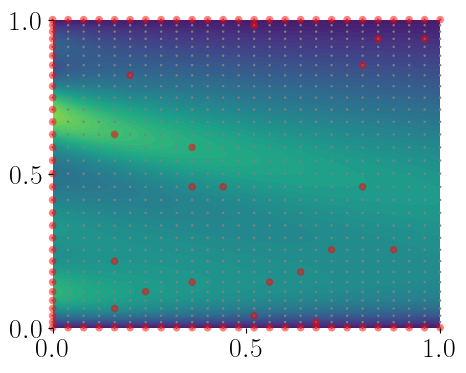

In [59]:
# u true1 with 20 obs
plt.figure(figsize=(5,4))
plt.tricontourf(*tx_fine.T, u_true1,
                levels= 50,
                vmin= vmin,
                vmax= vmax)
# coll grid
plt.scatter(*tx_all.T,
            c='gray',
            s = 3,
            clip_on =False, 
            edgecolors = 'none')
# obs grid
plt.scatter(*tx_obs1.T,
            c='red', 
            s = 30, 
            alpha = 0.5,
            clip_on =False,
            edgecolors = 'none')

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
# plt.gca().set_xticklabels([]) 

# save fig
plt.savefig('u_true_nobs1.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            )

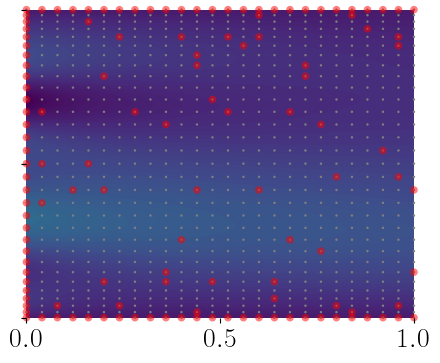

In [58]:
# u true2 with 50 obs
plt.figure(figsize=(5,4))
plt.tricontourf(*tx_fine.T, u_true2,
                levels= 50,
                vmin= vmin,
                vmax= vmax)
# coll grid
plt.scatter(*tx_all.T,
            c='gray',
            s = 3,
            clip_on =False, 
            edgecolors = 'none')
# obs grid
plt.scatter(*tx_obs2.T,
            c='red', 
            s = 30, 
            alpha = 0.5,
            clip_on =False,
            edgecolors = 'none')

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
# plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([]) 

# save fig
plt.savefig('u_true_nobs2.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            )

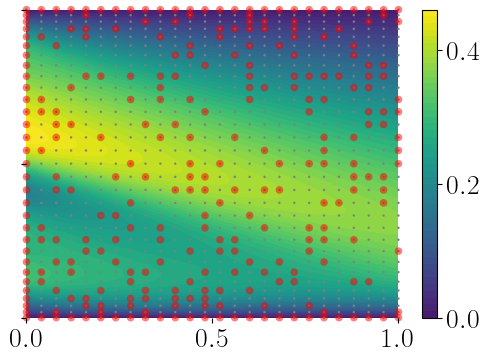

In [61]:
# u true3 with 200 obs
plt.figure(figsize=(6,4))
cp = plt.tricontourf(*tx_fine.T, u_true3,
                levels= 50,
                vmin= vmin,
                vmax= vmax)
cb = plt.colorbar(cp)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()
# coll grid
plt.scatter(*tx_all.T,
            c='gray',
            s = 3,
            clip_on =False, 
            edgecolors = 'none')
# obs grid
plt.scatter(*tx_obs3.T,
            c='red', 
            s = 30, 
            alpha = 0.5,
            clip_on =False,
            edgecolors = 'none')

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
# plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([]) 

# save fig
plt.savefig('u_true_nobs3.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            )